# Prevendo El Niño Southern Oscillation por meio de Séries Temporais
-----------------------
Essa é a parte 2 da tentativa de prever os eventos de El Ninõ e La Ninã que ocorrem no planeta.
Na parte 1, utilizamos os recursos presentes nas análises de *Complex Network* juntamente com as ferramentas de *Machine Learning* com o intuito de prever as ocorrências de mudanças climáticas registradas em uma faixa do pacífico, exibida na imagem abaixo, 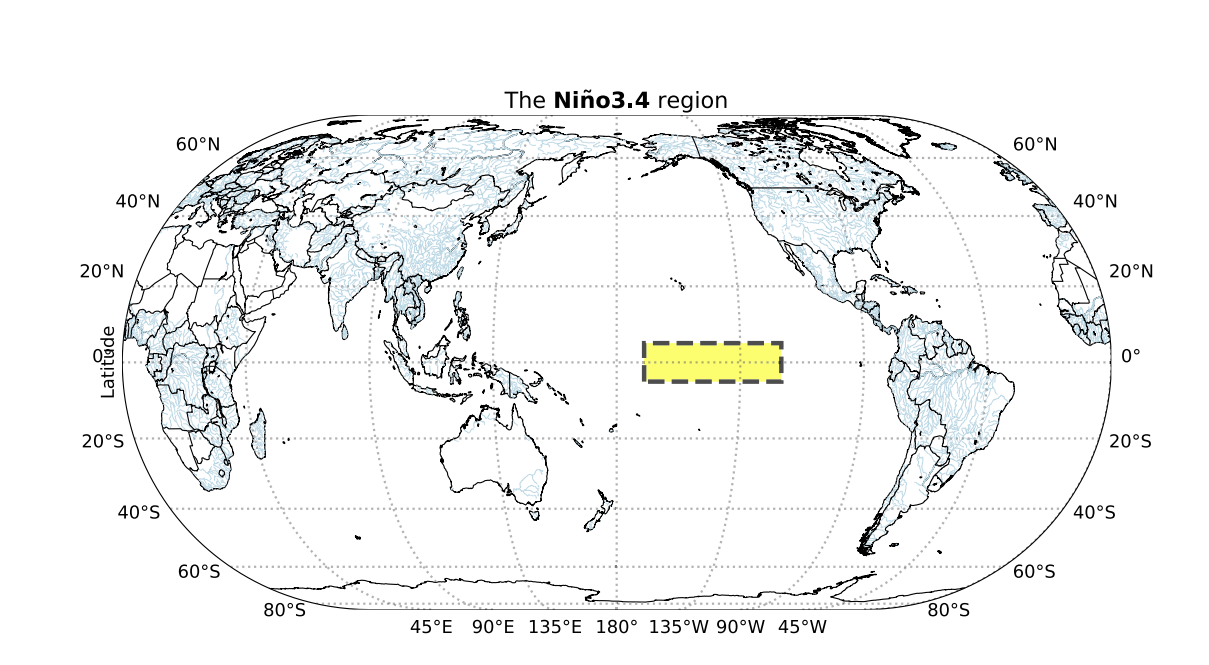

Acontece que utilizando das ferramentas presentes no campo das redes complexas, para caracterização as redes criadas, como o grau médio $\langle\langle k\rangle\rangle$, transitividade $(\tau)$, *Eigenvector centralities (Ev)*, e outras mais não deram certo. Acabamos tendo um grande bloco de variáveis extremamente correlacionadas e as que foram para a modelagem (*k, Ev*), o modelo não conseguiu distinguir os eventos e a precisão do modelo ficou precária.

Com isso, tivemos a ideia de realizar uma abordagem diferente, utilizando a **análise de séries temporais** e tentando prever futuros eventos de El Niño.

O banco de dados que utilizaremos aqui, foi gerado na primeira etapa do projeto e consiste apenas das datas e dos *ONI values* observados, i.e., a temperatura média registrada para os próximos 3 meses na faixa representada acima, o calculo feito desse index para esse estudo difere um pouco do que é tido por centrais climáticas, uma vez que o intuito disto é prever futuros acontecimentos. Para exemplo, no momento em que escrevo isto, no dia 05/12/2022, o *ONI value* seria referente à Jan/2023, Fev/2023 e Mar/2023.

Abaixo segue um link, com o site da *National Weather Service (NWS)* em que é atualizado todo mês esse indicador, mas em relação aos 3 meses passados.
https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

## Imports

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15,6)
sns.set_style("whitegrid")

### Criando o df

In [4]:
df = pd.read_csv("df_final.csv")
# df = pd.read_csv('ENSO.csv')

In [5]:
df

,k,Ev,mes-ano,ONI
0,1059.885744,0.368446,Jul-49,-0.307215
1,1041.655398,0.340432,Aug-49,-0.362405
2,1139.098795,0.335549,Sep-49,-0.440912
3,1202.009958,0.320051,Oct-49,-0.420933
4,1200.949686,0.322875,Nov-49,-0.397324
...,...,...,...,...
874,1382.297956,0.341262,May-22,-0.622985
875,1416.191562,0.351016,Jun-22,-0.438312
876,1397.723532,0.346507,Jul-22,-0.340677
877,1263.408281,0.348751,Aug-22,-0.206874


In [6]:
# dropando as colunas que não usaremos
df.drop(columns=["k", "Ev"], inplace=True)

In [7]:
# set data como datetime
df['data'] = pd.date_range('1949-07-01', periods=879, freq='M')
df.drop(columns="mes-ano", inplace=True)

In [8]:
df.set_index("data", inplace=True)

## Visualização

In [9]:
fig = px.line(df, title="Ocorrências de eventos El Niño e La Niña")
aux_el_nino = df[df['ONI']>=0.5]
aux_la_nina = df[df['ONI']<=-0.5]
for date in aux_el_nino.index:
    fig.add_vline(x=date, line_color="red",opacity=0.2)
for date in aux_la_nina.index:
    fig.add_vline(x=date, line_color="lightblue",opacity=0.4)
fig.show()

Podemos ver que não há muita regularidade com relação aos períodos de acontecimentos dos eventos. Por exemplo a La Niña no início dos dados aperecia com uma sequência maior do que as que foram registradas mais recentemente.

Outro ponto importante de citar é que essas temperaturas são apenas as **anomalias**, i.e., pegamos a temperatura registrada por exemplo em **Mar/2004**, essa **temperatura é subtraída da temperatura média dos meses de março** de todo o banco de dados, assim garantimos que se o gráfico acima indica um El Niño/La Niña é porque a temperatura média daquele mês está 0.5° acima ou abaixo da séries temporal daquele mês.

Sendo assim, a série aparenta ser estacionária, mas isso garantiremos mais a frente com um teste estatístico.

## Séries Temporais por Ano

In [8]:
df_ano = df.copy()
df_ano["ano"] = list(df.index.year)
df_ano["mes"] = list(df.index.month)

In [9]:
seq_color = [f'rgb({x-np.sqrt(x)}, {x}, {x+np.square(x)})' for x in range(3, 3*len(df_ano.ano), 3)]

In [10]:
px.line(df_ano, x="mes", y="ONI", color="ano", color_discrete_sequence=seq_color)

Talvez com o passar dos anos a temperatura tenha aumentado um pouco, olhando para algumas linhas mais escuras embaixo e algumas claras em cima, mas não conseguimos afirmar com certeza que houve um aumento ou diminuição das temperatura registradas.

## Separar um conjunto para teste

Antes de continuar a análise, vamos separar um conjunto de dados para testar os modelos depois. Como as dados estão dispostos mês a mês vamos colocar 3 anos para predição, um total de 36 meses.

In [10]:
df_treino = df.iloc[:-36] 
df_teste = df.iloc[-36:]

In [12]:
df_treino.index[-1]

Timestamp('2019-09-30 00:00:00')

In [13]:
df_teste.index[0]

Timestamp('2019-10-31 00:00:00')

## Decomposição da Série Temporal

Para um melhor entendimento do mecanismo de uma série temporal, um método bastante conhecido é a decomposição por médias móveis, que consiste em pegar nossa série $Y(t)$ e separar a tendência $T(t)$, a sazonalidade $S(t)$ e o ruído $e(t)$ presente nela.
Dessa forma ficamos com $Y(t)=T(t)+S(t)+e(t)$ e análisando termo a termo individualmente fica mais fácil de compreender o comportamento.

<AxesSubplot:title={'center':'Resíduos'}, xlabel='data'>

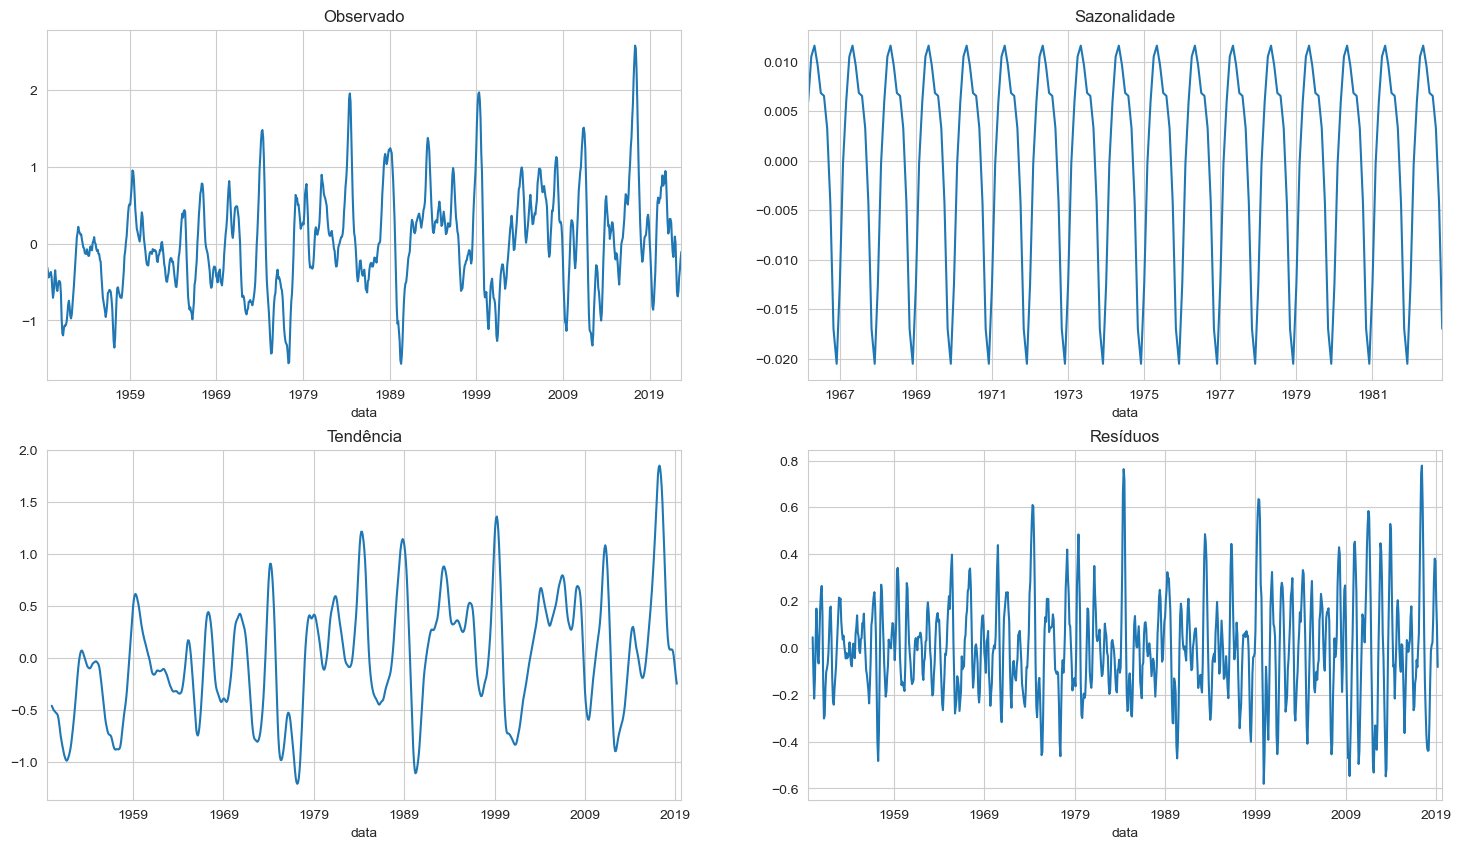

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_treino, model = 'additive')

sazonalidade, tendencia, ruido = decompose.seasonal, decompose.trend, decompose.resid

df_aux_dec = pd.DataFrame({'Observado': df.ONI,
                          'Sazonalidade': sazonalidade,
                          'Tendência': tendencia,
                          'Ruído': ruido}, index = df.index)

plt.figure(figsize = (18, 10))
# Observado
plt.subplot(2,2,1); df.ONI.plot(title = 'Observado')

# Sazonalidade
plt.subplot(2,2,2); sazonalidade[200:401].plot(title = 'Sazonalidade')

# Tendência
plt.subplot(2,2,3); tendencia.plot(title = 'Tendência')

# Resíduos
plt.subplot(2,2,4); ruido.plot(title = 'Resíduos')

Podemos chegar há algumas conclusões com esses gráficos representados acima, primeiro que na curva da sazonalidade (apenas 200 observações para melhorar a visibilidade) é possível ver claramentes ciclos anuais, onde a temperatura cresce no meio do ano em Jun/Jul e em Dez/Jan cai, mas isso tudo com uma variação baixa.
Olhando agora para a tendência, temos mais certeza ainda do que foi observado no gráfico de séries temporais por ano, há um leve aumento na temperatura média da faixa do El Niño e complementado pelo gráfico a variação aparenta ser crescente também com o passar dos anos.

Agora que temos uma noção do comportamento da temperatura da região El Niño com os passar dos anos, chegou a hora de realizamos o teste e verificar se essa série é estacionária.

E mais a frente na hora de modelar, vamos utilizar o modelo mais conhecido de séries temporais, o **SARIMA**. Basicamente é um modelo mais complexo do ARIMA que consiste em um modelo de 3 parâmetro **AR** (*autoregressive*) que olha para quantos lags (defasagens) iremos realizar a auto-regressão, o **I** (*integrated*) que seria exatamente quantas diferenciações são necessárias para garantir a estacionaridade e por fim o *MA* (*moving average*) que mostra a combinação linear dos ruídos.
O que tem a mais no SARIMA são os parâmetros encapsulados em **S**, que seriam os mesmos parâmetros descritos acima, mas olhando para a série sazional.

## Teste de Estacionaridade

In [15]:
# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, 
# with the alternative that there is no unit root. 
# If the pvalue is above a critical size, then we cannot reject that there is a unit root.

def teste_estacionaridade(serie):
    # teste
    result = adfuller(serie)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
         print('\t%s: %.3f' % (key, value))
    print(f'Result: Há fortes indícios de que a série {"não" if result[1] <= 0.05 else ""} tem raiz unitária e portanto {"" if result[1] <= 0.05 else "não"}é estacionária')

In [16]:
teste_estacionaridade(df_treino)

ADF Statistic: -6.051698
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Result: Há fortes indícios de que a série não tem raiz unitária e portanto é estacionária


Assim temos uma série estacionária e com isso já descobrimos o primeiro parâmetro do nosso modelo SARIMA, para o parâmetro **I** utilizaremos o valor $1$.

## ACF e PACF

Outra ferramenta importante na análise de séries temporais, são os gráficos da ACF (*Autocorrelation Function*) e da PACF (*Partial Autocorrelation Function*), a primeira consiste em ver como os lags carregam a correlação passando pelas obsrevações seguintes até chegar a observação mais recente e isso pode nos dizer qual o melhor valor para associar o parâmetro **MA**, para a PACF conseguimos ver diretamente a correlação da observação com o lag(t-1) ou lag(t-2) ou lag(t-3) e assim por diante, com isso teremos acesso ao **AR**.

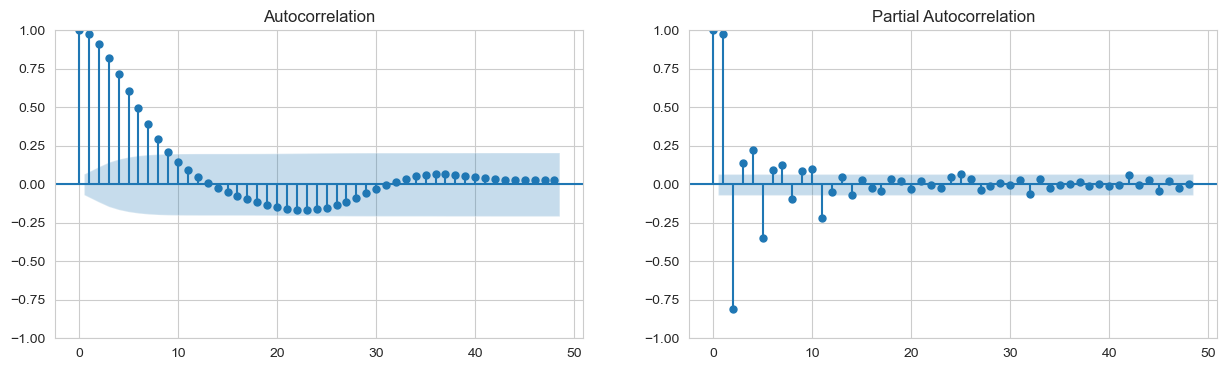

In [17]:
#plot_acf(X_diff, lags=20), plot_pacf(X_diff, lags = 20)
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = plot_acf(df_treino.iloc[1:], lags=48, ax=axes[0])
fig = plot_pacf(df_treino.iloc[1:], lags=48, ax=axes[1], method ='ywm')

In [16]:
# TODO: testar normalidade
# TODO: sazonalidade?
# TODO: trocar dataset para ENSO
# TODO: explicar serie
# TODO: ajustar modelo
# TODO: apresentacao gráfica
# TODO: usar para previsão e conclusão
# TODO: tratar e visualizar os dados

Olhando para o gráfico da ACF, conseguimos ver que temos 10 pirulitos acima do intervalo de confiança, então podemos estimar que o valor de **MA** será $10$ e para o gráfico da PACF temos um comportamento diferente, mas olhando para os pirulitos vamos atribuir à **AR** o valor $9$.

Como percebemos anteriormente que tinha uma sazonalidade, aqui ela se mostrou no gráfico da PACF onde no lag 12 temos um aumento no tamanho, sendo assim para os parâmetros sazionais de período 12 meses vamos ter $AR=1$, $I=0$ e $MA=0$.

## Criação do Modelo

In [18]:
# fit
modelo = SARIMAX(df_treino, order=(9,0,10), seasonal_order=(1,0,0,12), freq="M").fit()

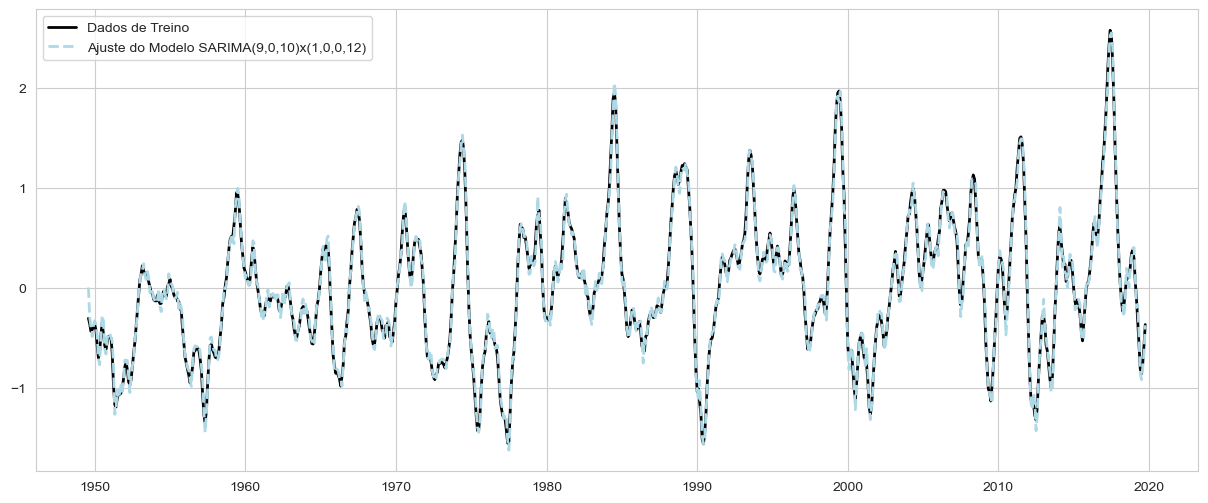

In [19]:
# plot
plt.plot(df_treino, color="black", lw=2, label="Dados de Treino")
plt.plot(modelo.predict(type="levels"), "--", color="lightblue", lw=2, label="Ajuste do Modelo SARIMA(9,0,10)x(1,0,0,12)")
plt.legend()

O modelo conseguiu se ajustar muito bem ao conjuntos de dados, o que já era esperado por ser o conjunto onde foi treinado, isso significa que os parâmetros também estão bem ajustados.

Agora vamos testar ele com um "novo" conjunto de dados, df_treino que separamos para validar se realmente o modelo está funcionando.

In [20]:
# predições
SARIMA_pred = modelo.forecast(steps=36)
# TODO: ver IC

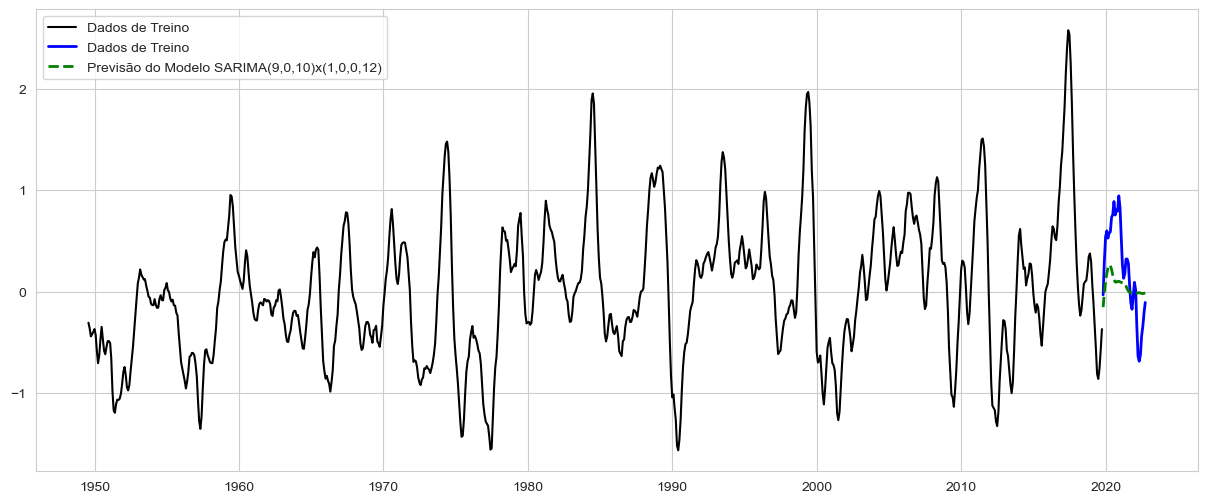

In [21]:
# plot
plt.plot(df_treino, color="black", label="Dados de Treino")
plt.plot(df_teste, color="blue", lw=2, label="Dados de Treino")
plt.plot(SARIMA_pred, "--", color="green", lw=2, label="Previsão do Modelo SARIMA(9,0,10)x(1,0,0,12)")
plt.legend()

In [22]:
df_teste.iloc[0]

ONI   -0.03296
Name: 2019-10-31 00:00:00, dtype: float64

Péssimo resultado nas previsões :(
O que aconteceu aqui, foi a junção dos erros a cada mês seguinte que o modelo tentou prever no conjunto, quanto maior o horizonte de previsão mais o nosso modelo tem dificuldades de enxergar um possível valor e até por isso que a curva das previsões vai se achatando conforme o tempo passa.

Um método mais robusto de previsão é chamado de *sliding window*, basicamente prevemos um ponto por vez e para cada novo ponto reajustamos o modelo e também nosso conjunto de dados de treino aumenta.

Exemplo: O nosso conjunto de dados para treinar o modelo vai até Out/2019, a previsão que observamos no plot acima foi a previsão de 36 pontos com apenas esses dados e um único modelo, no *sliding window* modelamos um ARIMA e realizamos a previsão apenas do mês Nov/2019 o que garante uma maior chance do modelo prever um valor próximo do real, para o próximo mês Dez/2019 treinamos um novo modelo (com mesmos parâmetros) tendo agora os dados que ele já havia treinado mais a previsão que o primeiro modelo fez do mês de Nov/2019, para o próximo a mesma coisa, dados de treino até Dez/2019 para prever a temperatura média do mês de Jan/2020 e assim por diante...

In [22]:
sliding_window = pd.DataFrame()
sliding_window_index = df.iloc[-37:].index

for mes in range(1, len(sliding_window_index)):
    dados_treino = df[:sliding_window_index[mes-1].date()]
    
    modelo = SARIMAX(dados_treino, order=(9,0,10), seasonal_order=(1,0,0,12), freq="M").fit()
    
    pred = modelo.forecast()
    sliding_window = pd.concat([sliding_window, pred], axis=0)
    
    
    print(f"Início dos dados de treino: {dados_treino.index[0].date()}")
    print(f"Fim dos dados de treino: {dados_treino.index[-1].date()}")
    print(f"Previsão de {pred.index[-1].date()}: {pred.values} (Real: {df.loc[df.index[mes]].values})")
    print("=============================\n")

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2019-09-30
Previsão de 2019-10-31: [-0.1534998] (Real: [-0.36240476])

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2019-10-31
Previsão de 2019-11-30: [0.24167533] (Real: [-0.4409121])

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2019-11-30
Previsão de 2019-12-31: [0.61196665] (Real: [-0.42093292])

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2019-12-31
Previsão de 2020-01-31: [0.62584154] (Real: [-0.39732447])

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2020-01-31
Previsão de 2020-02-29: [0.56491494] (Real: [-0.3695269])

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2020-02-29
Previsão de 2020-03-31: [0.4556777] (Real: [-0.42945546])

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2020-03-31
Previsão de 2020-04-30: [0.61962628] (Real: [-0.58291996])

Início dos dados de treino: 1949-07-31
Fim dos dados de tr

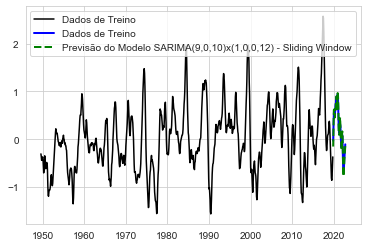

In [23]:
# plot
plt.plot(df_treino, color="black", label="Dados de Treino")
plt.plot(df_teste, color="blue", lw=2, label="Dados de Treino")
plt.plot(sliding_window, "--", color="green", lw=2, label="Previsão do Modelo SARIMA(9,0,10)x(1,0,0,12) - Sliding Window")
plt.legend()

Podemos ver claramente o ganho de desempenho/redução de erro que o modelo demonstrou com ao *sliding window*.
Agora que já temos um modelo bem ajustado e uma predição muito boa, vamos para os resultados métricas de validação.

## Resultados

Aqui vamos avaliar o modelo de duas formas:
+ Utilizando métricas de regressões
+ Utilizando métricas de classificações (comparar com o obtido na parte 1 do projeto)

### Regressão - SMAPE, MAPE & MSE

In [24]:
def metricas_reg(model_name, yhat, ytrue):
    smape_ = smape(ytrue, yhat)
    mape = np.mean(np.abs((ytrue - yhat)/ytrue))*100
    mse = mean_squared_error(ytrue, yhat)
    
    dc = {'SMAPE': smape_,
          'MAPE': mape,
          'MSE': mse}
    
    return pd.DataFrame(data= dc, index=[model_name])

A média simétrica de erro percentual absoluto (**SMAPE**) é uma medida de precisão baseada em erros percentuais (ou relativos). Definida da seguinte forma:

$$\dfrac{100\%}{n}\dfrac{|F_t-A_t|}{\dfrac{(|A_t|+|F_t|)}{2}}$$

Vamos usar também o erro quadrático médio **MSE**.

$$\dfrac{1}{n}\sum_{i=1}^{n}(Yi-\hat{Y})^2$$

In [25]:
metricas_reg("SARIMA(9,0,10)x(1,0,0,12) - Sliding Window", sliding_window, df_teste)
# TODO: comparar outros modelos

,SMAPE,MAPE,MSE
"SARIMA(9,0,10)x(1,0,0,12) - Sliding Window",32.005902,NaN,0.007932


O SMAPE ficou com o erro um pouco inflamado, porém em comparação o MSE teve um ótimo resultado.

### Classificação - Matriz de Confusão 

- $\text{ONI} < -0.5 = \text{La Nina}$
- $\text{ONI} > 0.5 = \text{El Nino}$
- $-0.5 \leq \text{ONI} \leq 0.5 = \text{AE}$

In [26]:
df_aux = sliding_window.rename(columns={0: "ONI"})

In [27]:
# transformando os valores em El Niño, La Niña e AE.
# Predito
classif_pred = df_aux["ONI"].apply(lambda x: "El Niño" if x > 0.5 else "La Ninã" if x < -0.5 else "AE")

# Observado
classif_obs = df_teste["ONI"].apply(lambda x: "El Niño" if x > 0.5 else "La Ninã" if x < -0.5 else "AE")

In [28]:
pd.DataFrame([classif_obs, classif_pred])

,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
ONI,AE,AE,El Niño,El Niño,El Niño,El Niño,El Niño,El Niño,El Niño,El Niño,...,AE,AE,AE,La Ninã,La Ninã,La Ninã,AE,AE,AE,AE
ONI,AE,AE,El Niño,El Niño,El Niño,AE,El Niño,El Niño,El Niño,El Niño,...,AE,AE,AE,La Ninã,La Ninã,La Ninã,La Ninã,AE,AE,AE


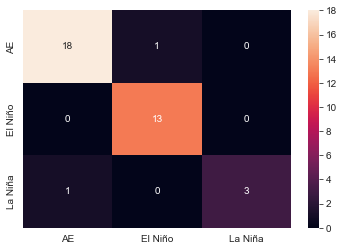

In [29]:
cm = confusion_matrix(classif_pred, classif_obs)

sns.heatmap(cm, annot=True, xticklabels=["AE", "El Niño", "La Niña"], yticklabels=["AE", "El Niño", "La Niña"]);

## Por fim, vamos realizar a previsão do que pode acontecer em um horizonte de 3 anos.

In [90]:
df2 = df.copy()

In [91]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 879 entries, 1949-07-31 to 2022-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ONI     879 non-null    float64
dtypes: float64(1)
memory usage: 46.0 KB


In [ ]:
# TODO: botar IC

In [110]:
# Utilizaremos todo o conjunto de dados agora
# copiando os dados
df2 = df.copy()

forecast_2026 = pd.date_range(start="2022-09-30", end="2026-01-01", freq="M")

for mes in range(1, len(forecast_2026)):
    dados_treino = df2[:forecast_2026[mes-1].date()]
    
    modelo = SARIMAX(dados_treino, order=(9,0,10), seasonal_order=(1,0,0,12), freq="M").fit()
    
    pred = modelo.forecast()
    df2 = pd.concat([df2, pd.DataFrame({"ONI": pred})], axis=0)    
    
    print(f"Início dos dados de treino: {dados_treino.index[0].date()}")
    print(f"Fim dos dados de treino: {dados_treino.index[-1].date()}")
    print(f"Previsão de {pred.index[-1].date()}: {pred.values}")
    print("=============================\n")

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2022-09-30
Previsão de 2022-10-31: [0.04080212]

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2022-10-31
Previsão de 2022-11-30: [0.20644695]

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2022-11-30
Previsão de 2022-12-31: [0.34264097]

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2022-12-31
Previsão de 2023-01-31: [0.39393239]

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2023-01-31
Previsão de 2023-02-28: [0.36600928]

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2023-02-28
Previsão de 2023-03-31: [0.29863015]

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2023-03-31
Previsão de 2023-04-30: [0.26632257]

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2023-04-30
Previsão de 2023-05-31: [0.25860587]

Início dos dados de treino: 1949-07-31
Fim dos dados de treino: 2023-05-31
Previsão de 2023-06-3

In [114]:
df2.iloc[-39:]

,ONI
2022-10-31,0.040802
2022-11-30,0.206447
2022-12-31,0.342641
2023-01-31,0.393932
2023-02-28,0.366009
2023-03-31,0.298630
2023-04-30,0.266323
2023-05-31,0.258606
2023-06-30,0.255617
2023-07-31,0.217473


In [ ]:
fig = px.line(df2.iloc[-39:], title="Previsão ne novas ocorrências de eventos El Niño e La Niña")
aux_el_nino = df2[df2.iloc[-39:]>=0.5]
aux_la_nina = df2[df2.iloc[-39:]<=-0.5]
for date in aux_el_nino.index:
    fig.add_vline(x=date, line_color="red",opacity=0.2)
for date in aux_la_nina.index:
    fig.add_vline(x=date, line_color="lightblue",opacity=0.4)
fig.show()

Assim concluímos este projeto de classificação de El Niño/La Niña, tivemos dificuldades para ajustar um modelo de classificação baseado nas métricas de redes complexas, o que pode ser muito útil para demais problemas mas não caiu bem neste caso.
Seguimos para uma análise de séries temporais utilizando modelos SARIMA e conseguimos explicar bem esse fenômeno natural que mexe com todo o planeta.